## Predicting student performance based on initial activity: a study in machine learning

---
_Mariko Makhmutova  
Supervisor: Rudiger Urbanke  
Information Processing Group, EPFL_

---
The purpose of this study is to see to what extent one can predict the performance of a MOOC user in a class based on their activity in the course during the first ten days of the course using a regression model. The data used for this project was provided by the EPFL Center for Digital Education.

In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, model_selection, metrics, preprocessing
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import itertools

### Data collection
The input data comes from the Digital Signal Processing class on Coursera, EPFL's MOOC with the most students enrolled. The session for this course started on February 18, 2013. The cut-off date for the input values to our model is ten days after the official start of the course, so February 28, 2013.

In [2]:
init_date = 1361145600
cut_off = init_date + 60*60*24*10

course = 'dsp-001'

In [3]:
conn = pymysql.connect(host='****', user='****', password='****', db='semester_projects')
cur = conn.cursor()
video_info = ("""SELECT VideoID, Title, OpenTime
                FROM semester_projects.mooc_coursera_video_info
                WHERE DataPackageID='%s' AND OpenTime IS NOT NULL
                AND VideoID IS NOT NULL AND OpenTime < %s""" % (course, str(cut_off)))
user_videos = ("""SELECT SessionUserID, COUNT(DISTINCT VideoID) as 'VideosWatched'
        FROM semester_projects.mooc_coursera_video_events
        WHERE DataPackageID='%s' AND TimeStamp < %s
        GROUP BY SessionUserID
        """ % (course, str(cut_off)))
user_assignments_all = ("""SELECT SessionUserID, TimeStamp, ProblemID, SubmissionNumber, Grade
        FROM semester_projects.mooc_coursera_problem_events_with_info
        WHERE DataPackageID='%s' AND Grade IS NOT NULL AND (ProblemID > 0)
        """ % course)
df_video_info = pd.read_sql(video_info, conn)
df_user_videos = pd.read_sql(user_videos, conn)
user_info = pd.read_sql(user_assignments_all, conn)
conn.close()

### Data processing
#### Initial processing

In [4]:
# casting objects into known types
def to_string(s):
    return s.replace('\x00', '')

user_info['SessionUserID'] = user_info['SessionUserID'].apply(to_string).astype(str)
user_info['ProblemID'] = user_info['ProblemID'].apply(to_string).astype(int)
df_user_videos['SessionUserID'] = df_user_videos['SessionUserID'].apply(to_string).astype(str)

Next, we calculate the maximum grade attained for each problem assigned. We take these grades as the maximum attainable grades, which we label as "MaxGrade". We only consider problems that have maximum grades between 3 and 100, to reduce the number of outliers.

Again, to ignore outliers, we only consider problems that have at least a thousand submissions by the end of the entire course session. (There are some problems that have had less than five submissions, whereas the others have had 10000, so we want to ignore these.)

In [5]:
# calculating maximum grade obtained for all problems
# NOTE: only keeping problems with maximum grades above or equal to 3
problem_max = pd.DataFrame(user_info.groupby(['ProblemID'])['Grade'].max())\
    .reset_index().query('Grade >= 3 & Grade <= 100')
problem_max = problem_max.rename(columns={'Grade': 'MaxGrade'})

# to filter out computational errors from Coursera, we only look at submissions that have positive grades less than 100
user_info = user_info.merge(problem_max, on='ProblemID', sort=False).query('Grade <= 100 & Grade >= 0')

During the processing of data, I noticed that there can sometimes be a large disparity between the maximum attainable grades, which caused the mean grades to be more varied. To avoid this "stretching" of the data, I decided to calculate grades as percentages of the maximum attainable grade, which reduced the range of my grades and final means from (0, 100) to (0, 1).

In [6]:
# for the model, we are only taking into account problems that have had over 1000 submissions by the end of the course
submissions_per_problem = user_info.groupby(['ProblemID'])['SessionUserID'].nunique().reset_index()
problems = submissions_per_problem.query('SessionUserID >= 1000')['ProblemID'].values

# filtering only relevant problems
user_info = user_info[user_info['ProblemID'].isin(problems)]

# calculating grades as a percentage of maximum attainable grade
user_info['Percentage'] = (user_info['Grade'] / user_info['MaxGrade']).apply(lambda x: round(x, 3))

In [7]:
# filtering users who were active during the first week
user_info_fw = user_info.query('TimeStamp < @cut_off')

# activity timestamp not needed for future calculations
user_info_fw = user_info_fw.drop('TimeStamp', axis=1)

# filtering only problems assigned (submitted > 500 times) during the first week
submissions_per_problem_fw = user_info_fw.groupby(['ProblemID'])['SessionUserID'].nunique().reset_index()
problems_fw = submissions_per_problem_fw.query('SessionUserID > 500')['ProblemID'].values
user_info_fw = user_info_fw[user_info_fw['ProblemID'].isin(problems_fw)]

Since the purpose of this project is to predict a user's success based on their activity during the first week, we will only be looking at the users that were active during the first week of the course.

In [8]:
users = np.array(user_info['SessionUserID'].unique())

Next, we create a dataframe to store the grades of every student for every assignment - this way, we account for the assignments that have not had any submissions by a given student. We repeat this for the first week.

In [9]:
assignment_grades = pd.DataFrame(user_info.groupby(['SessionUserID', 'ProblemID'])['Percentage'].max()).reset_index()

user_grades = pd.DataFrame({'SessionUserID': np.repeat(users, len(problems)),
          'ProblemID': np.tile(problems, len(users)),
          'Percentage': np.zeros(len(users) * len(problems))})

user_grades.update(assignment_grades)

In [10]:
assignment_grades_fw = assignment_grades[assignment_grades['ProblemID'].isin(problems_fw)]

user_grades_fw = pd.DataFrame({'SessionUserID': np.repeat(users, len(problems_fw)),
          'ProblemID': np.tile(problems_fw, len(users)),
          'Percentage': np.zeros(len(users) * len(problems_fw))})
user_grades_fw.update(assignment_grades_fw)

##### Model input and output variables

The input variables are the following three measurements:
- the number of assignment submissions per user
- the user's average grade (taking into account only the problems available during the ten days of the course)
- the number of videos the user has watched so far

The output is a boolean value that indicates whether a user has passed the course or not, based on the final average grade (0 to 1), with a passing grade at 65%.

In [11]:
# creating input dataframe of user statistics for ML model
# adding number of submissions
user_stats = pd.DataFrame({'Submissions': user_info_fw.groupby('SessionUserID').size(),
                          'InitAverage': np.nan})

# adding user first week averages
means = pd.DataFrame.from_dict(data=user_grades_fw.groupby('SessionUserID')['Percentage'].mean())
means = means.rename(columns={'Percentage': 'InitAverage'})
user_stats['InitAverage'] = user_stats.combine_first(means).apply(lambda x: round(x, 3))

# adding number of videos watched
user_stats = pd.merge(user_stats.reset_index(), df_user_videos, sort=False).dropna()

# calculating final average grade
user_grades = user_grades.drop('ProblemID', axis=1)
final_averages = pd.DataFrame(user_grades.groupby('SessionUserID')['Percentage'].mean()).reset_index()
final_averages = final_averages.rename(columns={'Percentage': 'FinalAverage'})

# adding final average grade
user_stats = pd.merge(user_stats, final_averages, sort=False)
user_stats['FinalAverage'] = user_stats['FinalAverage'].apply(lambda x: round(x, 3))

In [12]:
# SessionUserID is no longer needed
user_stats = user_stats.drop('SessionUserID', axis=1)

#### Data visualization
We now visualize our three input variables to see how they are distributed and to detect any obvious outliers visually.

In [13]:
# save initial user stats for model comparison
user_stats_init = user_stats.copy()

In [14]:
plt.style.use('ggplot')
%matplotlib inline

InitAverage         Axes(0.125,0.125;0.227941x0.755)
Submissions      Axes(0.398529,0.125;0.227941x0.755)
VideosWatched    Axes(0.672059,0.125;0.227941x0.755)
dtype: object

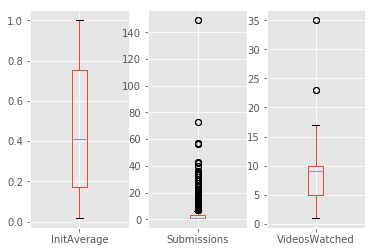

In [15]:
user_stats.drop('FinalAverage', axis=1).plot(kind='box', subplots=True)

Here, we can see that there are clearly outliers in the Submissions and VideosWatched variables. We want to see how the data distribution changes for these two variables if we remove the users that have either submitted over 20 times or have watched over 20 videos.

In [16]:
user_stats = user_stats.query('Submissions < 20 & VideosWatched < 20')

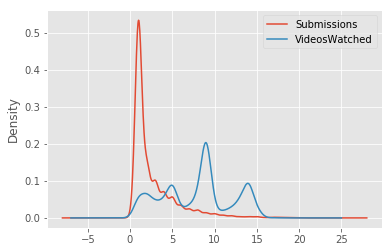

In [17]:
user_stats.drop(['InitAverage', 'FinalAverage'], axis=1).plot(kind='density')

Removing the outliers has has resulted in a neater distribution of the VideosWatched variable.

We notice, however, that the Submissions variable graph is highly concentrated around 1. This is problematic, as having at least half of the training set have a constant Submissions value will not train the model efficiently. To avoid having a relatively constant input variable, we will ignore all users that have submitted an assignment only once during the first ten days of the course. This leaves us with a total of 7344 users to train and test the model.

In [18]:
user_stats = user_stats.query('Submissions > 1')

Before we standardize our variables and train our model, we verify that the input values are all well-distributed without any obvious issues in the data.

InitAverage         Axes(0.125,0.125;0.227941x0.755)
Submissions      Axes(0.398529,0.125;0.227941x0.755)
VideosWatched    Axes(0.672059,0.125;0.227941x0.755)
dtype: object

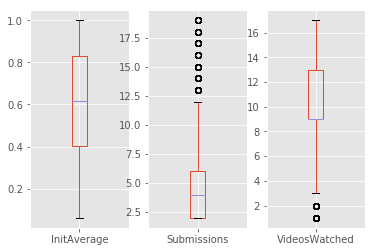

In [19]:
user_stats.drop('FinalAverage', axis=1).plot(kind='box', subplots=True)

#### Standardizing variables
We will be constructing a logistic regression model from our data, so in order to reduce the variation in the model's weights of the variables, we manipulate them to look like a standard normal distribution.

In [20]:
def standardize(col):
    return (col - col.mean()) / col.std()

for col in user_stats.columns[:-1]:
    user_stats[col] = standardize(user_stats[col])

#### Calculating output variable
Predicting a user's final grade percentage is difficult without hundreds of thousands of input values, so we reduced the problem to seeing whether a user passes or not, setting the passing mark at the final average being greater than or equal to 65%.

In [21]:
# adding pass result
user_stats['Pass'] = user_stats['FinalAverage'].apply(lambda x: x >= 0.65)

### Training a model
Now that our input variables have been parsed, cleaned and standardized, and we have established our boolean output variable, we are ready to train our model. We train the model on a set of 5344 inputs, and keep 2000 inputs as a test for our model.

In [22]:
input_variables = ['Submissions', 'InitAverage', 'VideosWatched']
data_X = user_stats.as_matrix(columns=input_variables)

test_size = 2000
data_X_train = data_X[:-test_size]
data_X_test = data_X[-test_size:]

data_y = (user_stats['Pass']).astype(int)

data_y_train = data_y[:-test_size]
data_y_test = data_y[-test_size:]

In [23]:
model = LogisticRegression()

kfold = model_selection.KFold(n_splits=10)
model.fit(data_X_train, data_y_train)
cv_results = model_selection.cross_val_score(model, data_X, data_y, cv=kfold)
msg = "%s: %.4f (%.4f)" % ("Logistic regression cross-validation accuracy (standard deviation)",
                           cv_results.mean(), cv_results.std())
print(msg)
expected = data_y_test
predicted = model.predict(data_X_test)
print("Test accuracy score: %.4f" % metrics.accuracy_score(expected, predicted))
coef = model.coef_[0]
print("Model coefficients: submissions %f, mean %f, videos watched %f" % (coef[0], coef[1], coef[2]))
print(model.intercept_)
print("Number of people who pass in predictions from test: %d" % np.count_nonzero(predicted))
print("Actual number of people who pass in test: %d" % np.count_nonzero(expected))
print("Predict pass, but fail: %d" % np.greater(predicted, expected).sum())
print("Predict fail, but pass: %d" % np.less(predicted, expected).sum())

Logistic regression cross-validation accuracy (standard deviation): 0.7510 (0.0163)
Test accuracy score: 0.7435
Model coefficients: submissions 0.478379, mean 0.386199, videos watched 0.365001
[-1.15555581]
Number of people who pass in predictions from test: 181
Actual number of people who pass in test: 536
Predict pass, but fail: 79
Predict fail, but pass: 434


### Conclusion

The goal of this project was to study to what extent we are able to predict a user's success in a MOOC based on how they interact with the online platform in the first ten days of a course session, by creating and training a regression model. It was unclear as to whether a clear conclusion could be reached from the very beginning, considering that MOOCs generally have a passing rate of approximately 15%, as studied by Dr Katy Jordan, during her doctoral studies at Open University.

Through some data analysis and cleanup, 7344 users with a more "normal" behaviour were used to train and test a logistic regression model. The reason for the use of a logistic regression model is that it shows a clear relationship between the input and the output variables whilst providing a relatively accurate model. Other, more complicated, models have also been tested throughout the course of this project, and the logistic regression model performed just as well, if not better than most.

The resulting model provides a 75% accuracy model that generally predicts that fewer people pass than the actual number of people that do. From the model coefficients, it can be deduced that the number of submissions per user is the highest factor in determining whether a student passes or not, but all of the factors have coefficients of the same order, so the difference in importance is rather small - all of the factors affect a user's passing grade.

An improvement for this project would be to use a larger training set, which could be done by analysing a course with even more users or by training the model on users from different courses, in an attempt to get more accurate predictions. Another way to increase the accuracy of the model would be to consider the measure of a user's success as multidimensional by, for example, taking into account the number of videos a user has watched by the end of the course as well as their final average. Giving different weights to each of the measures of success could give more accurate predictions.

In conclusion, the resulting model can predict the success of a MOOC user only to a certain extent. This shows that one cannot accurately predict whether a user will pass a course or not based on how active they are in the beginning. A possibility for a future experiment would be to see whether users who work consistently throughout the course succeed better than those who work sporadically, or to see whether we can predict the success of students based on what time of day they are active on the course.

### Appendices
#### Appendix 1
Comparing unprocessed data to processed data, and saying that even though the accuracy score is higher, the model is less able to predict outcomes, because it suppposes that the passing rate in the test case is at 95%, when the actual passing rate is about 15% with the unprocessed data.

In [24]:
user_stats_init['Pass'] = user_stats_init['FinalAverage'].apply(lambda x: x >= 0.65)

data_X_init = user_stats_init.as_matrix(columns=['Submissions', 'InitAverage', 'VideosWatched'])

test_size = 4000
data_X_train_init = data_X_init[:-test_size]
data_X_test_init = data_X_init[-test_size:]

data_y_init = (user_stats_init['Pass']).astype(int)

data_y_train_init = data_y_init[:-test_size]
data_y_test_init = data_y_init[-test_size:]

model_init = LogisticRegression()

model_init.fit(data_X_train_init, data_y_train_init)
cv_results_init = model_selection.cross_val_score(model_init, data_X_init, data_y_init, cv=kfold)
msg = "%s: %.4f (%.4f)" % ("Logistic regression cross-validation accuracy (standard deviation)",
                           cv_results_init.mean(), cv_results_init.std())
print(msg)
expected_init = data_y_test_init
predicted_init = model.predict(data_X_test_init)
print("Test accuracy score: %.4f" % metrics.accuracy_score(expected_init, predicted_init))
coef_init = model_init.coef_[0]
print("Model coefficients: submissions %f, mean %f, videos watched %f" % (coef_init[0], coef_init[1], coef_init[2]))
print("Number of people who pass in predictions from test: %d" % np.count_nonzero(predicted_init))
print("Actual number of people who pass in test: %d" % np.count_nonzero(expected_init))
print("Predict pass, but fail: %d" % np.greater(predicted_init, expected_init).sum())
print("Predict fail, but pass: %d" % np.less(predicted_init, expected_init).sum())

Logistic regression cross-validation accuracy (standard deviation): 0.8588 (0.0065)
Test accuracy score: 0.2018
Model coefficients: submissions 0.154611, mean 2.368289, videos watched 0.116055
Number of people who pass in predictions from test: 3783
Actual number of people who pass in test: 596
Predict pass, but fail: 3190
Predict fail, but pass: 3


#### Appendix 2
We also compare the results of the logistic regression model on all the possible combinations of input variables possible. We can see in the results of the computed models, that there is a clear amelioration in predictions with more variables being taken into account, with the number of submissions being the most conclusive single input variable. As we deduced from the three input variable model, the number of submissions in the first days of the course plays a big role in whether a student passes the course or not. 

In [25]:
kfold = model_selection.KFold(n_splits=10)
test_size = 2000

for r in range(1, 3):
    for permutation in itertools.combinations(input_variables, r):
        data_X = user_stats.as_matrix(columns=permutation)
        
        data_X_train = data_X[:-test_size]
        data_X_test = data_X[-test_size:]
        
        data_y = (user_stats['Pass']).astype(int)
        data_y_train = data_y[:-test_size]
        data_y_test = data_y[-test_size:]
        
        model = LogisticRegression()
        model.fit(data_X_train, data_y_train)
        cv_results = model_selection.cross_val_score(model, data_X, data_y, cv=kfold)
        print("Testing for inputs: %s" % (str(permutation)))
        msg = "%s: %.4f (%.4f)" % ("Cross-validation accuracy (standard deviation)",
                                   cv_results.mean(), cv_results.std())
        print(msg)
        expected = data_y_test
        predicted = model.predict(data_X_test)
        print("Test accuracy score: %.4f" % metrics.accuracy_score(expected, predicted))

Testing for inputs: ('Submissions',)
Cross-validation accuracy (standard deviation): 0.7428 (0.0150)
Test accuracy score: 0.7350
Testing for inputs: ('InitAverage',)
Cross-validation accuracy (standard deviation): 0.7360 (0.0167)
Test accuracy score: 0.7320
Testing for inputs: ('VideosWatched',)
Cross-validation accuracy (standard deviation): 0.7360 (0.0167)
Test accuracy score: 0.7320
Testing for inputs: ('Submissions', 'InitAverage')
Cross-validation accuracy (standard deviation): 0.7461 (0.0116)
Test accuracy score: 0.7390
Testing for inputs: ('Submissions', 'VideosWatched')
Cross-validation accuracy (standard deviation): 0.7471 (0.0150)
Test accuracy score: 0.7370
Testing for inputs: ('InitAverage', 'VideosWatched')
Cross-validation accuracy (standard deviation): 0.7416 (0.0105)
Test accuracy score: 0.7380
